<a href="https://colab.research.google.com/github/Humble-LiuAo/Regression-HW1-/blob/main/regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Download Data**

In [1]:
tr_path = 'covid.train.csv'  # path to training data
tt_path = 'covid.test.csv'   # path to testing data

!gdown --id '19CCyCgJrUxtvgZF53vnctJiOJ23T5mqF' --output covid.train.csv        #download
!gdown --id '1CE240jLm2npU-tdz81-oVKEF3T2yfT1O' --output covid.test.csv

import numpy as np      # linear algebra
import pandas as pd       # data processing

Downloading...
From: https://drive.google.com/uc?id=19CCyCgJrUxtvgZF53vnctJiOJ23T5mqF
To: /content/covid.train.csv
100% 2.00M/2.00M [00:00<00:00, 64.3MB/s]
Downloading...
From: https://drive.google.com/uc?id=1CE240jLm2npU-tdz81-oVKEF3T2yfT1O
To: /content/covid.test.csv
100% 651k/651k [00:00<00:00, 38.8MB/s]


In [2]:
import os
#for root, dirnames, filenames in os.walk('/content'):       # 遍历 return root dirnames filenames
   # for filename in filenames:
        #print(os.path.join(root,filename)) 
if os.path.exists('covid.test.csv') and os.path.exists('covid.train.csv'):
    print('exist data')

exist data


#**Import Some Packages**

In [3]:
# pytorch
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

# for data preprocess
import numpy as np
import csv
import os

# for plotting
import matplotlib.pyplot as plt
from matplotlib.pyplot import  figure

myseed = 2020875 # set a random seed
torch.backends.cudnn.deterministic = True   #if True, causes cuDNN to only use deterministic convolution algorithms.
torch.backends.cudnn.benchmark = False      #  if True, causes cuDNN to benchmark(基准) multiple convolution algorithms and select the fastest.
np.random.seed(myseed)
torch.manual_seed(myseed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(myseed)

In [4]:
x2 = range(556)[::200]  # [::] function
print(x2)
for i in x2:
    print(i)

range(0, 556, 200)
0
200
400


#**Some Utilities**

In [5]:
def get_device():
    '''Get device'''
    return 'cuda' if torch.cuda.is_available() else 'cpu'

def plot_learning_curve(loss_record, title=''):
    ''' Plot learning curve of your DNN (train & dev loss) '''
    total_steps = len(loss_record['train'])
    x_1 = range(total_steps)
    x_2 = x_1[ : :len(loss_record['train']) // len(loss_record['dev'])] # //:整除
    figure(figsize=(6, 4))
    # Case-insensitive Tableau Colors from 'T10' categorical palette.
    plt.plot(x_1, loss_record['train'], c='tab:red', label='train')
    plt.plot(x_2, loss_record['dev'], c='tab:cyan', label='dev')
    plt.ylim(0.0, 5.)
    plt.xlabel('Training steps')
    plt.ylabel('MSE loss')
    plt.title('learning curve of {}'.format(title))
    # Place a legend on the Axes.
    plt.legend()
    plt.show()


def plot_pred(dv_set, modelm, device, lim=35., preds=None, targes=None):
    '''Plot prediction of your DNN '''
    if preds is None or targets is None:
        model.eval()
        preds, targets=[], []
        for x, y in dv_set:
            x, y = x.to(device), y.to(device)
            with torch.no_grad():
                pred = model(x)
                # Returns a new Tensor, detached from the current graph.The result will never require gradient.  And to cpu
                preds.append(pred.detach().cpu())
                targets.append(y.detach().cpu())
        # Cat: concatenate multiple tensors
        preds = torch.cat(preds, dim=0).numpy()
        targets = torch.cat(targets, dim=0).numpy()

    figure(figsize=(5, 5))
    # A scatter plot of y vs. x with varying marker size and/or color.
    plt.scatter(targets, preds, c='r', alpha=0.5)   # The alpha blending value, between 0 (transparent) and 1 (opaque).
    plt.plot([-0.2,lim], [-0.2, lim], c='b')
    plt.xlim(-0.2, lim)
    plt.ylim(-0.2, lim)
    plt.xlabel('ground truth value')
    plt.xlabel('ground truth value')
    plt.title('Ground Truth v.s. Prediction')
    plt.show()

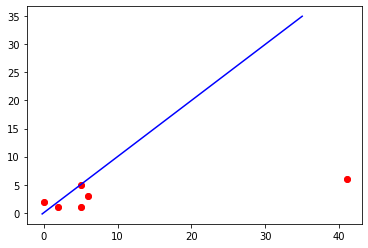

In [6]:
lim = 35
plt.plot([-0.2,lim], [-0.2, lim], c='b')
x = [5,6,5,41,2,0]
y = [1,3,5,6,1,2]
plt.scatter(x,y, c='r', alpha=0.5)
plt.scatter(x,y, c='r', alpha=1)

# **Preprocess**
We have three kinds of datasets:
* `train`: for training
* `dev`: for validation
* `test`: for testing (w/o target value)

## **Dataset**

The `COVID19Dataset` below does:
* read `.csv` files
* extract features
* split `covid.train.csv` into train/dev sets
* normalize features

Finishing `TODO` below might make you pass medium baseline.

**特征选择**

In [7]:
import pandas as pd
import numpy as np

data = pd.read_csv('/content/covid.train.csv')
x = data[data.columns[1:94]]
y = data[data.columns[94]]

# scikit learn 
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression

from sklearn import preprocessing
#  The minimum value for each column
x = (x - x.min()) / (x.max() - x.min())

# return object
bestfeatures = SelectKBest(score_func=f_regression, k=5)
#  fit-->train
fit = bestfeatures.fit(x,y)
# print(fit.scores_)
dfscores = pd.DataFrame(fit.scores_)
# print(dfscores)
# print(x.columns) # return Index([......])
dfcolumns = pd.DataFrame(x.columns)
#concat two dataframes for better visualization 
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
# print(featureScores)
featureScores.columns = ['Specs','Score']   #naming the dataframe columns
# Return the first n rows with the largest values in columns, indescending order. 
print(featureScores.nlargest(15,'Score'))   #print 15 best features

                 Specs          Score
75   tested_positive.1  148069.658278
57     tested_positive   69603.872591
42        hh_cmnty_cli    9235.492094
60      hh_cmnty_cli.1    9209.019558
78      hh_cmnty_cli.2    9097.375172
43      nohh_cmnty_cli    8395.421300
61    nohh_cmnty_cli.1    8343.255927
79    nohh_cmnty_cli.2    8208.176435
40                 cli    6388.906849
58               cli.1    6374.548000
76               cli.2    6250.008702
41                 ili    5998.922880
59               ili.1    5937.588576
77               ili.2    5796.947672
92  worried_finances.2     833.613191


In [8]:
# import numpy as np
# import pandas as pd

# data = pd.read_csv('/content/covid.train.csv')
# x = data.columns[1:94]
# x = data[data.columns[1:94]]
# print(x.min())
# x = (x - x.min()) / (x.max() - x.min())
# print(x)
# print(x.columns)
from sklearn.datasets import load_digits
from sklearn.feature_selection import SelectKBest, chi2
X, y = load_digits(return_X_y=True)
print(X.shape)
X_new = SelectKBest(chi2, k=20).fit_transform(X, y)
print(X_new.shape)

(1797, 64)
(1797, 20)


In [9]:
# read-->select feats if test--> get data if  train/dev --> get data and target and respective indices
# final convert torch.tensor
class COVID19Dataset(Dataset):
    '''Dataset for loading and preprocessing the COVID19 dataset '''
    def __init__(self,
                 path,
                 mode='train',
                 target_only =True):
        self.mode = mode
        # Read data into numpy arrays
        with open(path, 'r') as fp:
            #  read each row into list e.g. [[],[],[],....]
            data = list(csv.reader(fp))
            data = np.array(data[1:])[:, 1:].astype(float)
            
        # Forecast test positive for the third day
        if not target_only:
            feats = list(range(93))
            # feats = list(range(1, 40)) + [57, 75]
        else:
            feats = [75, 57, 42, 60, 78, 43, 61, 79, 40, 58, 76, 41, 59, 77]    #上面挑选的最优特征
        if mode == 'test':
            # Testing data
            # data: 893 x 93 (40 states + day 1 (18) + day 2 (18) + day 3 (17))
            data = data[:, feats]
            self.data = torch.FloatTensor(data)
        else:
            # Training data (train/dev sets)
            # data: 2700 x 94 (40 states + day 1 (18) + day 2 (18) + day 3 (18))
            target =data[:, -1]
            data = data[:, feats]
            # Splitting training data into train & dev sets
            # 在确定参数后，使用所有数据进行训练，即训练集=验证集
            if mode == 'train':
                #indices = [i for i in range(len(data)) if i % 10 != 0]
                indices = [i for i in range(len(data))]
            elif mode == 'dev':
                # indices = [i for i in range(len(data)) if i % 10 == 0]
                indices = [i for i in range(len(data))]
                # Convert data into PyTorch tensors
            self.data = torch.FloatTensor(data[indices])
            self.target = torch.FloatTensor(target[indices])
            # Normalize features
            # data = (data - mean) / std
        self.data[:, 40:] = \
            (self.data[:, 40:] - self.data[:, 40:].mean(dim=0, keepdim=True)) \
            / self.data[:, 40:].std(dim=0, keepdim=True)

        self.dim = self.data.shape[1]

        print('Finished reading the {} set of COVID19 Dataset ({} samples found, each dim = {})'
              .format(mode, len(self.data), self.dim))

    def __getitem__(self,index):
        # rerurn one sample at a time
        if self.mode in ['train', 'dev']:
            return self.data[index], self.target[index]
        else:
            # for testing(no target)
            return self.data[index]

    def __len__(self):
        # return the size of the dataset
        return len(self.data)

In [10]:
# with open('/content/covid.train.csv', 'r') as fp:
#         #  read each row into list e.g. [[],[],[],....]
#         data = list(csv.reader(fp))
#         data = np.array(data[1:])[:, 1:].astype(float)
#         data = torch.FloatTensor(data)
#         print(data)
#         a = data[:,40:].mean(dim=0,keepdim=True)
#         print(a)
#         print(a.shape)
data = torch.randn(4,5)
print(data)
mean = data.mean(dim=0,keepdim=True)
print(mean)
# data = data -mean
data = data/mean
print(data)

tensor([[ 0.1364, -0.5031, -0.7150,  0.3920,  0.2633],
        [-0.0767, -1.9232, -0.6323, -0.2896,  0.4500],
        [-0.8540,  0.3538,  0.5961,  0.1761,  0.9778],
        [-1.2692, -0.3051, -0.5610, -0.8085, -0.8379]])
tensor([[-0.5158, -0.5944, -0.3280, -0.1325,  0.2133]])
tensor([[-0.2645,  0.8465,  2.1796, -2.9587,  1.2344],
        [ 0.1486,  3.2355,  1.9275,  2.1858,  2.1097],
        [ 1.6555, -0.5953, -1.8173, -1.3294,  4.5839],
        [ 2.4603,  0.5133,  1.7101,  6.1023, -3.9279]])


## **DataLoader**

A `DataLoader` loads data from a given `Dataset` into batches.


In [11]:
def prep_dataloader(path, mode, batch_size, n_jobs=0, target_only=False):
    '''Generates a dataset, then is put into a dataloader'''
    dataset = COVID19Dataset(path, mode=mode, target_only=target_only)      # Construct dataset
    # num_workers (int, optional) – how many subprocesses to use for data loading.
    # pin_memory (bool, optional) – If True, the data loader will copy Tensors into CUDA pinned memory before returning them.
    # drop_last (bool, optional) – set to True to drop the last incomplete batch, if the dataset size is not divisible by the batch size
    dataloader = DataLoader(
        dataset,batch_size,
        shuffle=(mode == 'train'),drop_last = False,
        num_workers=n_jobs,pin_memory=True)
    return dataloader

# **Deep Neural Network**

`NeuralNet` is an `nn.Module` designed for regression.
The DNN consists of 2 fully-connected layers with ReLU activation.
This module also included a function `cal_loss` for calculating loss.


In [12]:
class NeuralNet(nn.Module):
    ''' A simple fully-connected deep neural network '''
    def __init__(self, input_dim):
        super(NeuralNet, self).__init__()

        # Define neural network here
        self.net = nn.Sequential(
            nn.Linear(input_dim, 32),    # Fully connected network
            nn.BatchNorm1d(32),         # Batch Normalization(0,1): Accelerating Deep Network Training by Reducing Internal Covariate Shift .
            nn.Dropout(p = 0.2),         # During training, randomly zeroes some of the elements of the input tensor with probability p using samples from a Bernoulli distribution 减少过拟合
            nn.LeakyReLU(),                 # relu activation
            nn.Linear(32, 1)
        )
        # Mean squared error loss
        self.criterion = nn.MSELoss(reduction='mean') #'mean': the sum of the output will be divided by the number of elements in the output
        #self.criterion = nn.SmoothL1Loss(size_average=True)
    def forward(self, x):
        ''' Given input of size (batch_size x input_dim), compute output of the network '''
        return self.net(x).squeeze(1)   # Delete the 1 - dimensional at the location
    
    def cal_loss(self, pred, target):
        '''Calculate loss'''
        regularization_loss = 0 # 正则项损失
        for param in model.parameters():
            # may implement L1/L2 regularization here
            # 使用L2正则项
            # regularization_loss += torch.sum(abs(param))
            regularization_loss += torch.sum(param ** 2)
        return self.criterion(pred, target) + 0.00075 * regularization_loss

In [13]:
x =torch.randn(5,3,1)
print(x)
print(x.squeeze(2))

tensor([[[ 0.8384],
         [ 2.0670],
         [-2.2105]],

        [[ 1.5372],
         [ 0.8064],
         [ 0.1125]],

        [[-0.0481],
         [ 0.2121],
         [-1.1779]],

        [[ 0.1820],
         [ 1.1300],
         [ 1.1597]],

        [[-0.7250],
         [ 0.5542],
         [ 0.6110]]])
tensor([[ 0.8384,  2.0670, -2.2105],
        [ 1.5372,  0.8064,  0.1125],
        [-0.0481,  0.2121, -1.1779],
        [ 0.1820,  1.1300,  1.1597],
        [-0.7250,  0.5542,  0.6110]])


# **Train/Dev/Test**

1.  each epoch : use tr_set accomplish optim-->use dv_set find out mse_loss and contrast
2. use loss_record{'train' [], 'dv': []} to record process



## **Training**


In [14]:
# epoch:  train -->optim dv-->output loss // record: loss_record = {'train': [], 'dev': []}
def train(tr_set, dv_set, model, comfig, device):
    '''DNN  training'''
    n_epochs = config['n_epochs']  # Maximum number of epochs

    # Setup optimizer
    # getattr: Return the value of the named attribute of object.
    # *不定长参数 **关键字参数
    optimizer = getattr(torch.optim, config['optimizer'])(
        model.parameters(), **config['optim_hparas'])   # model.parameters:  should be optimized/ default

    min_mse = 1000. # initial mse
    loss_record = {'train': [], 'dev': []}  # for recording training loss
    early_stop_cnt = 0
    epoch = 0

    while epoch < n_epochs:
        model.train()                                    # set model to training mode
        for x, y in tr_set:                                  # iterate through the dataloader
           optimizer.zero_grad()                       # set gradient to zero
           x, y = x.to(device), y.to(device)          # move data to device (cpu/cuda)
           pred = model(x)                              # forward pass (compute output)
           mse_loss = model.cal_loss(pred, y)   # compute loss
           mse_loss.backward()                      # compute gradient (backpropagation)
           optimizer.step()                                 # update model with optimizer
           loss_record['train'].append(mse_loss.detach().cpu().item())  # item(): Returns the value of this tensor as a standard Python number.
           # only one element tensors can convert p number

        # After each epoch, test your model on the validation (development) set.
        dev_mse = dev(dv_set, model, device)
        if dev_mse < min_mse:
            # Save model if your model improved
            min_mse = dev_mse
            print('Saving model (epoch = {:4d}, loss = {:.4f})'.format(epoch+1, min_mse))
            # state_dict(): Returns a dictionary containing a whole state of the module.
            torch.save(model.state_dict(), config['save_path'])             # Save model to specified path
            early_stop_cnt = 0
        else:
            early_stop_cnt += 1

        epoch += 1
        loss_record['dev'].append(dev_mse)
        if early_stop_cnt > config['early_stop']:
            # Stop training if model stops improving for "config['early_stop']" epochs.
            break
        
    print('Finished training after {} epochs'.format(epoch))
    return min_mse, loss_record

## **Validation**


1. Find out the total loss for each batch size and accumulate 
2.   total loss/ len(dv_set.dataset)



In [15]:
def dev(dv_set, model, device):
    model.eval()        # set model to evaluation mode
    total_loss = 0
    for x, y in dv_set:         # iterate through the dataloader
        x, y = x.to(device), y.to(device)       # move data to device (cpu/cuda)
        with torch.no_grad():           # disable gradient calculation 
            pred = model(x)             # forward pass (compute output)
            mse_loss = model.cal_loss(pred, y)   # compute loss
        total_loss += mse_loss.detach().cpu().item()*len(x)        # accumulate loss  *batch size
    total_loss = total_loss/len(dv_set.dataset)         # compute averaged loss
    return total_loss

## **Testing**

In [16]:
def test(tt_set, model, device):
    model.eval()            # set model to evalutation mode
    preds = []
    for x in tt_set:            # iterate through the dataloader
        x = x.to(device)            # move data to device (cpu/cuda)
        with torch.no_grad():       # disable gradient calculation
            pred = model(x)             # forward pass (compute output)
            preds.append(pred.detach().cpu())   # collect prediction
    preds = torch.cat(preds, dim=0).numpy()  # concatenate all predictions and convert to a numpy array
    # dim= 0 cat-->893*1
    return preds

# **Setup Hyper-parameters**

`config` contains hyper-parameters for training and the path to save your model.

In [17]:
device = get_device()
os.makedirs('models', exist_ok=True)        # If exist_ok is False (the default), an FileExistsError is raised if the target directory already exists.
target_only = False
# Set hyper-parameters to improve  model's performance
config = {
    'n_epochs': 10000,        # maximum number of epochs for train
    'batch_size': 200,          # mini_batch size for dataloader
    'optimizer': 'Adam',         # optimization algorithm (optimizer in torch.optim)
    # use default paras
    'optim_hparas':{        # hyper-parameters for the optimizer (depends on which optimizer you are using)
      #'lr': 0.001,                 # learning rate of Adam
       #'momentum': 0.9,     # momentum for Adam
        # 'weight_decay': 5e-4
    },
    'early_stop': 500,        # early stopping epochs (the number epochs since your model's last improvement)
     'save_path': 'models/model.pth'  # your model will be saved here
}

# **Load data and model**

In [18]:
tr_set =prep_dataloader(tr_path, 'train', config['batch_size'], target_only=target_only)
dv_set = prep_dataloader(tr_path, 'dev', config['batch_size'], target_only=target_only)
tt_set = prep_dataloader(tt_path, 'test', config['batch_size'], target_only=target_only)

Finished reading the train set of COVID19 Dataset (2700 samples found, each dim = 93)
Finished reading the dev set of COVID19 Dataset (2700 samples found, each dim = 93)
Finished reading the test set of COVID19 Dataset (893 samples found, each dim = 93)


In [19]:
model = NeuralNet(tr_set.dataset.dim).to(device) # Construct model and move to device

In [20]:
# batch size 
for x, y in tr_set:
        x, y=x.to(device), y.to(device)
        print(len(x))
        pred = model(x)                              # forward pass (compute output)
        mse_loss = model.cal_loss(pred, y)   # compute loss
        print(len(pred))
        print(mse_loss)
        

200
200
tensor(316.3053, device='cuda:0', grad_fn=<AddBackward0>)
200
200
tensor(318.1369, device='cuda:0', grad_fn=<AddBackward0>)
200
200
tensor(295.3010, device='cuda:0', grad_fn=<AddBackward0>)
200
200
tensor(323.3778, device='cuda:0', grad_fn=<AddBackward0>)
200
200
tensor(325.7643, device='cuda:0', grad_fn=<AddBackward0>)
200
200
tensor(312.3527, device='cuda:0', grad_fn=<AddBackward0>)
200
200
tensor(307.6223, device='cuda:0', grad_fn=<AddBackward0>)
200
200
tensor(325.0182, device='cuda:0', grad_fn=<AddBackward0>)
200
200
tensor(346.8696, device='cuda:0', grad_fn=<AddBackward0>)
200
200
tensor(333.9899, device='cuda:0', grad_fn=<AddBackward0>)
200
200
tensor(306.8732, device='cuda:0', grad_fn=<AddBackward0>)
200
200
tensor(351.3362, device='cuda:0', grad_fn=<AddBackward0>)
200
200
tensor(307.4668, device='cuda:0', grad_fn=<AddBackward0>)
100
100
tensor(358.6977, device='cuda:0', grad_fn=<AddBackward0>)


# **Start Training!**



In [21]:
model_loss, model_loss_record = train(tr_set, dv_set, model, config, device)

Saving model (epoch =    1, loss = 306.5018)
Saving model (epoch =    2, loss = 289.8238)
Saving model (epoch =    3, loss = 277.5685)
Saving model (epoch =    4, loss = 269.3286)
Saving model (epoch =    5, loss = 260.5027)
Saving model (epoch =    6, loss = 250.1268)
Saving model (epoch =    7, loss = 239.8289)
Saving model (epoch =    8, loss = 230.3675)
Saving model (epoch =    9, loss = 218.0973)
Saving model (epoch =   10, loss = 206.2140)
Saving model (epoch =   11, loss = 193.8723)
Saving model (epoch =   12, loss = 183.4781)
Saving model (epoch =   13, loss = 172.5012)
Saving model (epoch =   14, loss = 158.3388)
Saving model (epoch =   15, loss = 145.8008)
Saving model (epoch =   16, loss = 134.8515)
Saving model (epoch =   17, loss = 123.6831)
Saving model (epoch =   18, loss = 111.7418)
Saving model (epoch =   19, loss = 103.6647)
Saving model (epoch =   20, loss = 92.2775)
Saving model (epoch =   21, loss = 81.5850)
Saving model (epoch =   22, loss = 73.8991)
Saving model 

In [22]:
# print(model_loss_record['train'])
# print(model_loss_record['dev'])

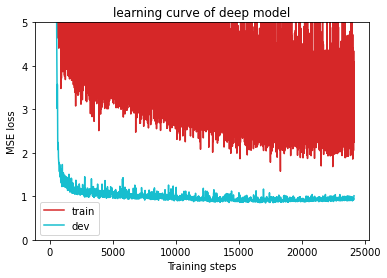

In [23]:
plot_learning_curve(model_loss_record, title='deep model')

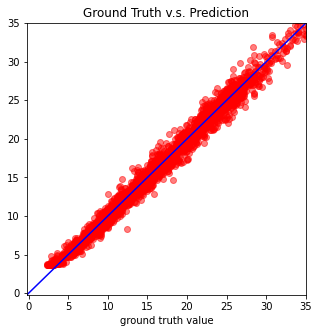

In [24]:
del model   # delete model
model = NeuralNet(tr_set.dataset.dim).to(device)
ckpt = torch.load(config['save_path'], map_location='cpu')  # Load your best model      ckpt = checkpoint(检查点)
model.load_state_dict(ckpt)         # #将 model(train )中的参数加载到 model(test) 中 
plot_pred(dv_set, model, device)  # Show prediction on the validation set

In [25]:
def save_pred(preds, file):
    ''' Save predictions to specified file '''
    print('Saving results to {}'.format(file))
    with open(file, 'w') as fp:
        writer = csv.writer(fp)     # return obj
        writer.writerow(['id', 'tested_positive'])  # Write the row parameter to the writer’s file object,
        for i, p in enumerate(preds):
            writer.writerow([i, p])

preds = test(tt_set, model, device)  # predict COVID-19 cases with your model
# print(preds)
save_pred(preds, 'pred.csv')         # save prediction file to pred.csv

Saving results to pred.csv


In [26]:
dict = {'a', 'sd', 'd'}
for i, p in enumerate(dict):
    print([i,p])

[0, 'a']
[1, 'd']
[2, 'sd']


# **Reference**
This code is completely written by Heng-Jui Chang @ NTUEE.  
Copying or reusing this code is required to specify the original author. 

E.g.  
Source: Heng-Jui Chang @ NTUEE (https://github.com/ga642381/ML2021-Spring/blob/main/HW01/HW01.ipynb)
